<a href="https://colab.research.google.com/github/THANNAGA/Lagrangian/blob/main/GLV_bounded_lagrangian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

!pip install git+https://github.com/cooper-org/cooper.git
import cooper
from copy import deepcopy as copy

  Cloning https://github.com/cooper-org/cooper.git to /tmp/pip-req-build-ybsx_3lx
  Running command git clone --filter=blob:none --quiet https://github.com/cooper-org/cooper.git /tmp/pip-req-build-ybsx_3lx
  Resolved https://github.com/cooper-org/cooper.git to commit eae7c5a68563b83410913c8b24e99b70e32694f3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Lagrangian classes

In [118]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.input_dim = input_dim
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        outputs = self.linear(x)
        return outputs


class NormConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to have norm less than or equal to 1
        # g(W) <= 1  ---> g(W) - 1 <= 0
        ineq_defect = model.linear.weight.norm(dim=1) - 1

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

class SumConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to sum to a negative
        # g(W) <= 0
        ineq_defect = model.linear.weight.sum(dim=1)

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=None)

class TemplateConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets, template):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want the sign of W to be equal to a template T.
        # g(W) == T ---> g(W) - T == 0
        eq_defect = (model.linear.weight.sign() - template).sum()

        return cooper.CMPState(loss=loss, ineq_defect=None, eq_defect=eq_defect)

class TemplateSumConstrainedLogReg(cooper.ConstrainedMinimizationProblem):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()
        super().__init__(is_constrained=True)

    def closure(self, model, inputs, targets, template):

        pred_logits = model.forward(inputs)
        loss = self.criterion(pred_logits, targets)

        # We want each row of W to sum to a negative
        # g(W) <= 0
        ineq_defect = model.linear.weight.sum(dim=1)

        # We want the sign of W to be equal to a template T.
        # g(W) == T ---> g(W) - T == 0
        eq_defect = (model.linear.weight.sign() - template).sum()

        return cooper.CMPState(loss=loss, ineq_defect=ineq_defect, eq_defect=eq_defect)

### Defining a toy weight matrix sign template in the context of Interactive Activation

In [119]:
# Define a function to check if a token is a word
def is_word(token):
    return token.isalpha()

# Define a function to get the position of a letter/position token
def get_position(token):
    return int(token[1:]) if not is_word(token) else None

def contains_letter(token, letter):
    return letter in token


def create_matrix(tokens=[], WtoL=0.01, LtoW=0.05, LtoL=-0.1, WtoW=-0.5):
  # Initialize the adjacency matrix with all zeroes
  adjacency_matrix = np.zeros((len(tokens), len(tokens)))

  for i in range(len(tokens)):
      for j in range(len(tokens)):
          if i == j:
              continue  # a token is not connected to itself
          if is_word(tokens[i]) and is_word(tokens[j]):
              # Two word tokens are always connected with a -1
              adjacency_matrix[i, j] = WtoW
          elif not is_word(tokens[i]) and not is_word(tokens[j]) and get_position(tokens[i]) == get_position(tokens[j]):
              # Two letter/position tokens are connected with a -1 if they have the same position
              adjacency_matrix[i, j] = LtoL

  # Iterate over the tokens again to add +1 connections
  for i in range(len(tokens)):
      for j in range(len(tokens)):
          if is_word(tokens[i]) and not is_word(tokens[j]) and contains_letter(tokens[i], tokens[j][0]):
              # If a word token contains a letter/position token, there is a positive LtoWExc connection between them
              adjacency_matrix[i, j] = WtoL
              adjacency_matrix[j, i] = LtoW
  return adjacency_matrix

In [120]:
tokens = ['a1', 'b2', 'c1', 'd2', 'ab', 'cd', 'ad']
#tokens = ['a1', 'b2', 'ab']
n = len(tokens)
A = create_matrix(tokens = tokens)

### Defnining a toy dataset in the context of interactive activation

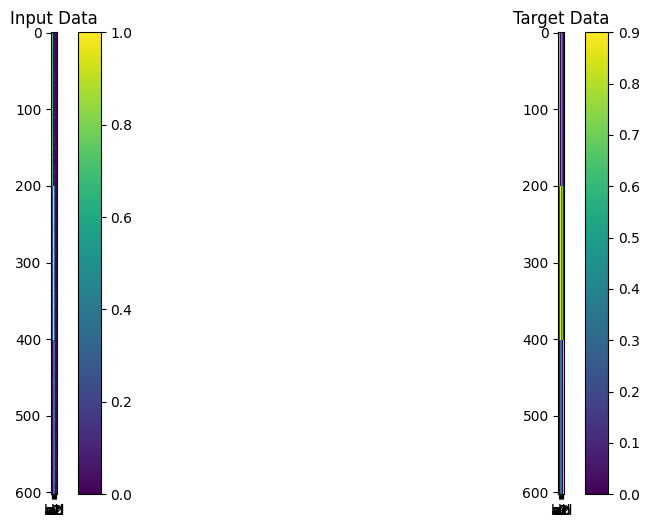

In [121]:
# Adjust the word to letter mapping to account for the position of the letters
word_to_letters = {word: [f'{letter}{i+1}' for i, letter in enumerate(word)] for word in tokens if is_word(word)}

# Initialize empty lists for input and target data
input_data = []
target_data = []

# Iterate over all word tokens
value = 0.9
for word, letters in word_to_letters.items():
    # Create input and target vectors for each word
    input_vector = [value if token in letters else 0 for token in tokens]
    target_vector = input_vector.copy()
    target_vector[tokens.index(word)] = value  # Set the corresponding word token to 1 in the target vector

    # Add the input and target vectors to the data
    input_data.append(input_vector)
    target_data.append(target_vector)

    # Create k variants with small perturbations
    for _ in range(200):
        perturbed_input_vector = [value + 0.05 * np.random.randn() for value in input_vector]
        # Make sure values are within [0, 1]
        perturbed_input_vector = np.clip(perturbed_input_vector, 0, 1)
        input_data.append(perturbed_input_vector)
        target_data.append(target_vector)

# Convert the lists to numpy arrays
input_data = np.array(input_data)
target_data = np.array(target_data)

# Plot the input and target data
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Input data
cax = ax[0].imshow(input_data, cmap='viridis')
fig.colorbar(cax, ax=ax[0])
ax[0].set_title('Input Data')
ax[0].set_xticks(np.arange(n))
ax[0].set_xticklabels(tokens)

# Target data
cax = ax[1].imshow(target_data, cmap='viridis')
fig.colorbar(cax, ax=ax[1])
ax[1].set_title('Target Data')
ax[1].set_xticks(np.arange(n))
ax[1].set_xticklabels(tokens)

plt.show()

# Assuming you have input_data and target_data as numpy arrays
input_data_torch = torch.from_numpy(input_data).float()
target_data_torch = torch.from_numpy(target_data).float()

### Training with lagrangian

In [122]:
#cmp = NormConstrainedLogReg(); equality = False
#cmp = SumConstrainedLogReg(); equality = False
#cmp = TemplateConstrainedLogReg()
cmp = TemplateSumConstrainedLogReg()
formulation = cooper.LagrangianFormulation(cmp)

model = LogisticRegression(A.shape[0], A.shape[1])

# primal_optimizer = cooper.optim.ExtraSGD(model.parameters(), lr=1e-3, momentum=0.9)
# dual_optimizer = cooper.optim.partial_optimizer(cooper.optim.ExtraSGD, lr=5e-3)

primal_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
dual_optimizer = cooper.optim.partial_optimizer(torch.optim.SGD, lr=5e-3)

coop = cooper.ConstrainedOptimizer(
    formulation=formulation,
    primal_optimizer=primal_optimizer,
    dual_optimizer=dual_optimizer,
)

In [123]:
epochs = 100
iter_num = 0
state_history = OrderedDict()

A = np.sign(A)
# Set the diagonal elements to -1
np.fill_diagonal(A, -1)
template = torch.from_numpy(np.sign(A)).float()
inputs = torch.from_numpy(input_data).float()
targets = torch.from_numpy(target_data).float()

for epoch in range(epochs):
      coop.zero_grad()
      lagrangian = formulation.composite_objective(
          cmp.closure, model, inputs, targets, template
        )
      formulation.custom_backward(lagrangian)
      coop.step(cmp.closure, model, inputs, targets, template)

      if iter_num % 5 == 0:
          state_history[iter_num] = {
                "cmp": cmp.state,
                "dual": copy(formulation.state()),
            }

      iter_num += 1

In [124]:
iters, loss_history = zip(
    *[(iter_num, _["cmp"].loss.item()) for (iter_num, _) in state_history.items()]
  )

mult_hist = [_["dual"][1].data.numpy() for (foo, _) in state_history.items()]
defect_hist = [_["cmp"].eq_defect.data.numpy() for (foo, _) in state_history.items()]

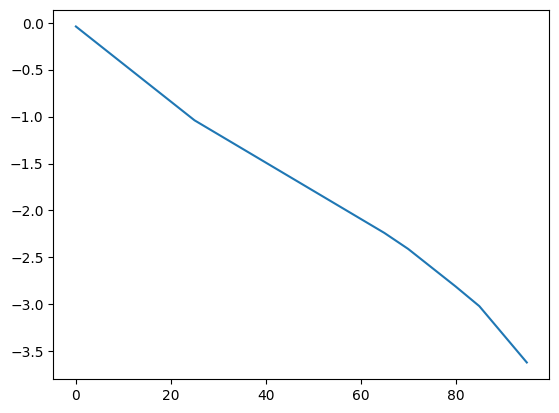

In [125]:
plt.plot(iters, mult_hist)
plt.show()

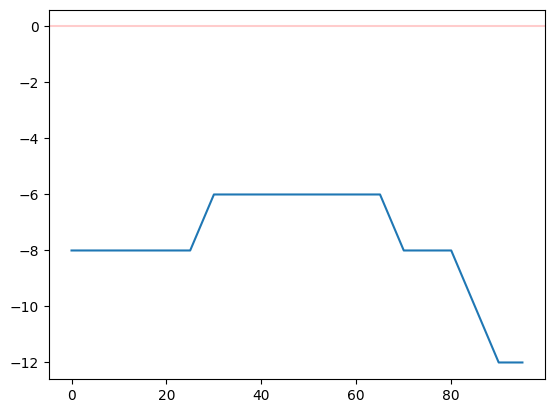

In [126]:
plt.plot(iters, defect_hist)
plt.axhline(0.0, c="r", alpha=0.2)
plt.show()

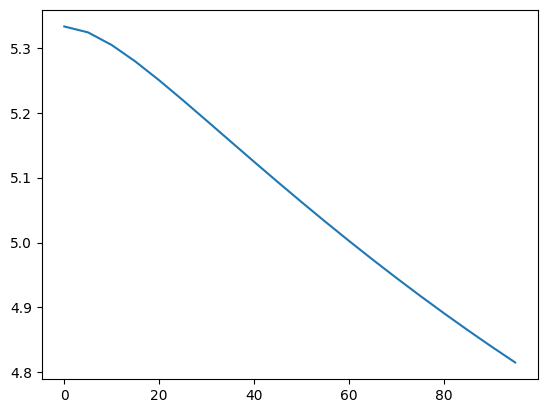

In [127]:
plt.plot(iters, loss_history)

In [128]:
def check_matrix_conditions(matrix, verbose=True):
  # Check if the matrix satisfies the conditions
  eigenvalues = np.linalg.eigvals(matrix)
  eigenvalues_real_parts = np.real(eigenvalues)
  row_sums = matrix.sum(axis=1)

  # All eigenvalues have negative real parts
  eigenvalues_condition = np.all(eigenvalues_real_parts < 0)

  # The sum of each row is negative
  row_sums_condition = np.all(row_sums < 0)

  # The matrix contains positive elements
  positive_elements_condition = np.any(matrix > 0)

  if verbose:
    print ('All eigenvalues have negative real parts:', eigenvalues_condition)
    print ('The sum of each row is negative:', row_sums_condition)
    print ('The matrix contains positive elements:', positive_elements_condition)

  return eigenvalues_condition, row_sums_condition, positive_elements_condition

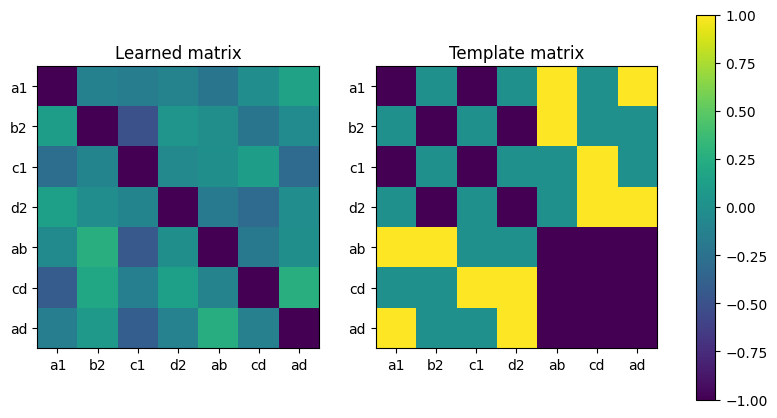

All eigenvalues have negative real parts: True
The sum of each row is negative: True
The matrix contains positive elements: True


(True, True, True)

In [129]:
A = model.linear.weight.detach().numpy()
np.fill_diagonal(A, -1)

# Determine the common color limits
vmin = min(A.min(), template.min())
vmax = max(A.max(), template.max())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first matrix with the common color limits
im1 = axs[0].imshow(A, vmin=vmin, vmax=vmax)
axs[0].set_title("Learned matrix")
axs[0].set_xticks(np.arange(len(tokens)))
axs[0].set_yticks(np.arange(len(tokens)))
axs[0].set_xticklabels(tokens)
axs[0].set_yticklabels(tokens)

# Plot the second matrix with the common color limits
im2 = axs[1].imshow(template, vmin=vmin, vmax=vmax)
axs[1].set_title("Template matrix")
axs[1].set_xticks(np.arange(len(tokens)))
axs[1].set_yticks(np.arange(len(tokens)))
axs[1].set_xticklabels(tokens)
axs[1].set_yticklabels(tokens)

# Create colorbar based on the first image
fig.colorbar(im1, ax=axs.ravel().tolist(), orientation='vertical')

#fig.tight_layout()
plt.show()

check_matrix_conditions(A)

Running Lotka-Volterra for interactive activation with Lagrangian-constrained weight matrix

r [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
X.shape (1000, 7)


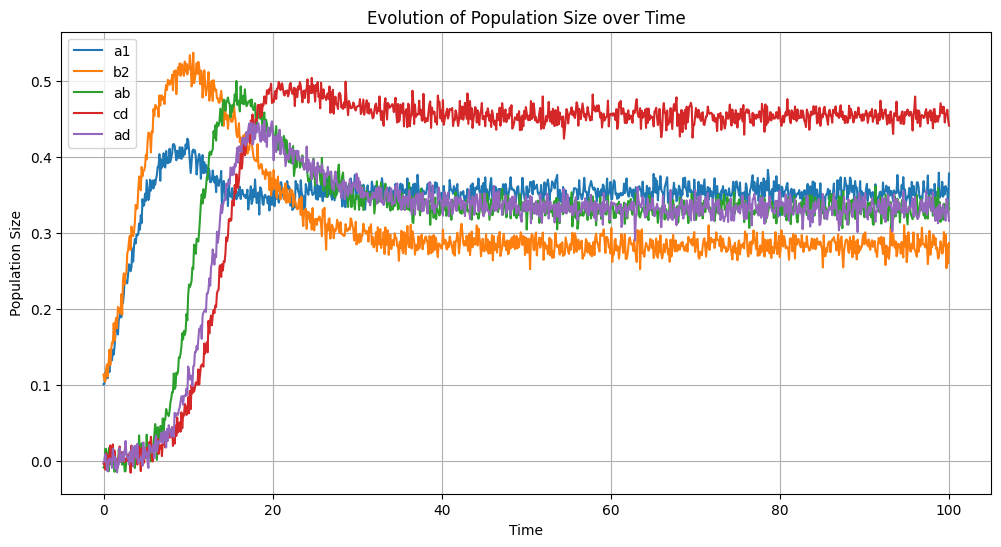

In [130]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Number of species
N = len(tokens)

# Let's set intrinsic growth rates such that r_i > 0
r = 0.5*np.ones(N)
print ('r', r)

#A = create_matrix(tokens = tokens)
#A = stabilize_matrix(A)
A = model.linear.weight.detach().numpy()

# Define the system of differential equations
def dXdt(X, t):
    return X * (r + np.dot(A, X))

# Initial conditions: start with equal populations
#X0 = 0.01*np.ones(N)
X0 = [0.1, 0.1, 0.001, 0.001, 0.001, 0.001, 0.001]

# Time points
T = 100
t = np.linspace(0, T, 1000)

# Solve the system of differential equations
X = odeint(dXdt, X0, t)

# Plot the results
plt.figure(figsize=(12, 6)); print ('X.shape', X.shape)

select = ['a1', 'b2', 'ab', 'cd', 'ad']
tokens = ['a1', 'b2', 'c1', 'd2', 'ab', 'cd', 'ad']
for i in range(X.shape[1]):
    if tokens[i] in select:
      plt.plot(t, X[:, i] +0.01*np.random.randn(X.shape[0]), label=tokens[i])
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.title('Evolution of Population Size over Time')
plt.grid(True)
plt.show()


Real parts of the eigenvalues of the Jacobian at the feasible equilibrium:
[-0.13774754 -0.20289195 -0.20289195 -0.43499054 -0.34768893 -0.29381626
 -0.29381626]


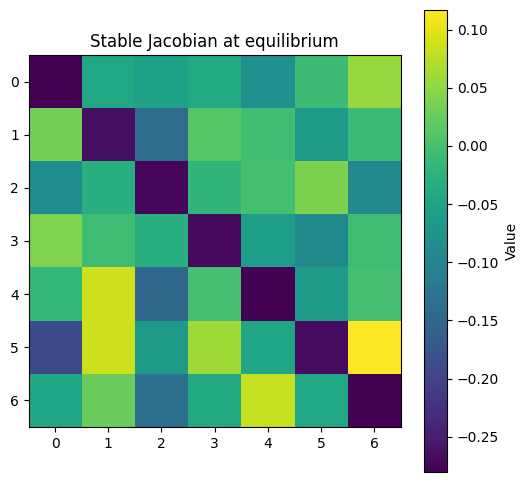

In [131]:
def jacobian(func, state, interaction_matrix, growth_rates):
    """Compute the Jacobian matrix of func at the given state."""
    n = len(state)
    jacobian_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                jacobian_matrix[i, j] = state[i] * (interaction_matrix[i, j] + int(i == j) * growth_rates[i])
            else:
                jacobian_matrix[i, j] = state[i] * (interaction_matrix[i, i] + growth_rates[i] + 2 * sum(interaction_matrix[i, k] * state[k] for k in range(n) if k != i))

    return jacobian_matrix

def check_stability(func, state, interaction_matrix, growth_rates):
    """Compute the Jacobian of func at the given state, check its stability, and display it."""
    # Compute the Jacobian
    jacobian_matrix = jacobian(func, state, interaction_matrix, growth_rates)

    # Compute the eigenvalues of the Jacobian
    eigenvalues = np.linalg.eigvals(jacobian_matrix)

    # Check if the real parts of all eigenvalues are negative
    is_stable = np.all(np.real(eigenvalues) < 0)

    # Display the Jacobian
    plt.figure(figsize=(6, 6))
    plt.imshow(jacobian_matrix, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title('Stable Jacobian at equilibrium' if is_stable else 'Unstable Jacobian at equilibrium')
    plt.show()

    return is_stable

# Compute the equilibrium
if np.linalg.det(A) != 0:
    equilibrium = -np.linalg.inv(A) @ r
    if np.all(equilibrium >= 0):  # Check if the equilibrium is feasible
        feasible_equilibrium = equilibrium
    else:
        feasible_equilibrium = None
else:
    feasible_equilibrium = None

# Compute the Jacobian at the feasible equilibrium and print the real parts of its eigenvalues
if feasible_equilibrium is not None:
    jacobian_at_equilibrium = jacobian(dXdt, feasible_equilibrium, A, r)
    eigenvalues = np.linalg.eigvals(jacobian_at_equilibrium)
    print("Real parts of the eigenvalues of the Jacobian at the feasible equilibrium:")
    print(np.real(eigenvalues))
    check_stability(dXdt, feasible_equilibrium, A, r)
else:
    print("The system does not have a feasible equilibrium.")

In [ ]:
import plotly.express as px
import numpy as np
import pandas as pd
from scipy.linalg import svd

# Perform Singular Value Decomposition (SVD) on the interaction matrix
U, S, Vt = svd(A)

# Select the top 3 modes
modes = Vt[:3, :]


# project initial trajectory onto modes
projection = X @ modes.T

# Prepare a color gradient to signify time
#colors = plt.cm.autumn(np.linspace(0, 1, len(t)))


# Set initial state for C1, D2
initial_state_new1 = [0.001, 0.001, 0.1, 0.1, 0.001, 0.001, 0.001]

# Solve the ODE system with the new initial state
solution_new = odeint(dXdt, initial_state_new1, t)

# Project the state's evolution with the new initial state onto the 3D space spanned by the top 3 modes
projection_new = solution_new @ modes.T

# Prepare a new color gradient to signify time
#colors_new = plt.cm.spring(np.linspace(0, 1, len(t)))



# Set initial state for A1, D2
initial_state_new2 = [0.1, 0.001, 0.001, 0.1, 0.001, 0.001, 0.001]

# Solve the ODE system with the new initial state
solution_new2 = odeint(dXdt, initial_state_new2, t)

# Project the state's evolution with the new initial state onto the 3D space spanned by the top 3 modes
projection_new2 = solution_new2 @ modes.T

# Prepare a new color gradient to signify time
#colors_new2 = plt.cm.summer(np.linspace(0, 1, len(t)))

# Project the equilibrium onto the 3D space spanned by the top 3 modes
equilibrium_projection = equilibrium @ modes.T

In [132]:
go = False
if go:
  # Assuming the definitions of X, modes, t, dXdt, initial_state_new1,
  # initial_state_new2, equilibrium and equilibrium_projection are above this comment

  # Create a DataFrame for each trajectory and then combine them
  df1 = pd.DataFrame(projection, columns=['Mode 1', 'Mode 2', 'Mode 3'])
  df1['Time'] = np.arange(len(df1))
  df1['Type'] = 'A1, B2'

  df2 = pd.DataFrame(projection_new, columns=['Mode 1', 'Mode 2', 'Mode 3'])
  df2['Time'] = np.arange(len(df2))
  df2['Type'] = 'C1, D2'

  df3 = pd.DataFrame(projection_new2, columns=['Mode 1', 'Mode 2', 'Mode 3'])
  df3['Time'] = np.arange(len(df3))
  df3['Type'] = 'A1, D2'

  df1['Time'] = df1['Time'] / df1['Time'].max()
  df2['Time'] = df2['Time'] / df2['Time'].max()
  df3['Time'] = df3['Time'] / df3['Time'].max()

  df = pd.concat([df1, df2, df3])

  # Create a 3D scatter plot for each trajectory
  fig1 = px.scatter_3d(df[df['Type']=='A1, B2'], x='Mode 1', y='Mode 2', z='Mode 3', color='Time', color_continuous_scale='reds')
  fig2 = px.scatter_3d(df[df['Type']=='C1, D2'], x='Mode 1', y='Mode 2', z='Mode 3', color='Time', color_continuous_scale='greens')
  fig3 = px.scatter_3d(df[df['Type']=='A1, D2'], x='Mode 1', y='Mode 2', z='Mode 3', color='Time', color_continuous_scale='blues')

  # Combine the plots
  fig = go.Figure(data=fig1.data + fig2.data + fig3.data)

  # Add the equilibrium point (if it exists)
  if equilibrium is not None:
      fig.add_trace(go.Scatter3d(x=[equilibrium_projection[0]],
                                y=[equilibrium_projection[1]],
                                z=[equilibrium_projection[2]],
                                mode='markers',
                                marker=dict(size=10, color='black'),
                                name='Equilibrium'))

  # Add dummy scatter for the legend
  for type, color in [('A1, B2', 'red'), ('C1, D2', 'green'), ('A1, D2', 'blue')]:
      start_point = df[df['Type'] == type].iloc[0]
      fig.add_trace(go.Scatter3d(
          x=[start_point['Mode 1']], y=[start_point['Mode 2']], z=[start_point['Mode 3']],
          mode='markers',
          marker=dict(size=6, color=color),
          name=type,
          showlegend=True
      ))

  # Update layout
  fig.update_layout(scene=dict(xaxis_title='Mode 1', yaxis_title='Mode 2', zaxis_title='Mode 3'),
                    title_text="Projection of State Evolutions onto Top 3 Modes with Different Initial States")

  # Update color bar to be horizontal
  fig.update_coloraxes(colorbar=dict(orientation="v", x=-0.1, len=0.5))

  fig.show()


In [134]:
import plotly.graph_objects as go

fig = go.Figure()

# Create a scatter plot for each trajectory
for type, color_scale in [('A1, B2', 'Reds'), ('C1, D2', 'Greens'), ('A1, D2', 'Blues')]:
    df_sub = df[df['Type'] == type]
    fig.add_trace(go.Scatter3d(x=df_sub['Mode 1'], y=df_sub['Mode 2'], z=df_sub['Mode 3'],
                               mode='markers',
                               marker=dict(size=6, color=df_sub['Time'], colorscale=color_scale),
                               name=type))

# Add the equilibrium point (if it exists)
if equilibrium is not None:
    fig.add_trace(go.Scatter3d(x=[equilibrium_projection[0]],
                               y=[equilibrium_projection[1]],
                               z=[equilibrium_projection[2]],
                               mode='markers',
                               marker=dict(size=10, color='black'),
                               name='Equilibrium'))

# Update layout
fig.update_layout(scene=dict(xaxis_title='Mode 1', yaxis_title='Mode 2', zaxis_title='Mode 3'),
                  title_text="Projection of State Evolutions onto Top 3 Modes with Different Initial States")

fig.show()
